# Project: Road Accidents in France based on Annual Road Traffic Accident Injury Database (2005 - 2023)

## Step 2: Baseline Models - 4-Class

Import required libraries and load the cleaned dataset containing accident records

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & feature engineering
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks


In [3]:
file_path = "../data/processed/df_for_ml.csv"
df = pd.read_csv(file_path, low_memory=False)

In [4]:
# Convert to 'category' dtype
category_columns = [
    'lum', 'int', 'atm', 'col', 'circ', 'vosp', 'prof', 'plan', 'surf',
    'infra', 'situ', 'senc', 'obs', 'obsm', 'choc', 'catu', 'grav', 'sexe',
    'dayofweek', 'belt_status', 'agg_catr', 'catv_group', 'rush_hour',
    'season', 'age_bin', 'belt_user_type_code'
]

for col in category_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Convert to nullable integers (Int64)
nullable_int_columns = ['nbv', 'age']
for col in nullable_int_columns:
    if col in df.columns:
        df[col] = df[col].astype('Int64')

# Leave 'hour' as standard integer
if 'hour' in df.columns:
    df['hour'] = df['hour'].astype('int64')

print(df.dtypes)

lum                    category
int                    category
atm                    category
col                    category
circ                   category
nbv                       Int64
vosp                   category
prof                   category
plan                   category
surf                   category
infra                  category
situ                   category
senc                   category
obs                    category
obsm                   category
choc                   category
catu                   category
grav                   category
sexe                   category
hour                      int64
dayofweek              category
belt_status            category
age                       Int64
agg_catr               category
catv_group             category
rush_hour              category
season                 category
age_bin                category
belt_user_type_code    category
dtype: object


In [7]:
# ----- PARAMETERS -----
use_full_data = False  # Set to True to use the full dataset
sample_fraction = 0.2  # 20% of the data

In [10]:
# ----- LABEL PROCESSING -----

# Map into 4 classes
grav_mapping = {
    1: "Unharmed",
    2: "Killed",
    3: "Hospitalized",
    4: "Light injury"
}
df["grav_label"] = df["grav"].map(grav_mapping)

# Optional sampling
if not use_full_data:
    df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)

# Encode target
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(df["grav_label"]))
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Drop label columns from input
X = df.drop(columns=["grav", "grav_label"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Detect feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()

# Distribution check
print("Class distribution:\n", y.value_counts(normalize=True).sort_index())
print("Class mapping:", class_mapping)


Class distribution:
 0    0.139590
1    0.016661
2    0.370262
3    0.473487
Name: proportion, dtype: float64
Class mapping: {'Hospitalized': 0, 'Killed': 1, 'Light injury': 2, 'Unharmed': 3}


#### Test of Feature Selection with `VarianceThreshold`

After one-hot encoding, we applied: `VarianceThreshold(threshold=0.05)` to remove low-variance (mostly zero) features and to reduce noise and overfitting

##### Test on 50% of data
- **Before:** 155 features  
- **After:** 78 features  

In [13]:
# 🧪 Sample 50% of training data
sample_frac = 0.5
X_sample = X_train.sample(frac=sample_frac, random_state=42)

# Select categorical columns only
X_cat = X_sample[categorical_features]

# Encode without VarianceThreshold
pipeline_no_thresh = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
X_encoded = pipeline_no_thresh.fit_transform(X_cat)
print(f"🔢 One-hot encoded feature count (before VarianceThreshold): {X_encoded.shape[1]}")

# Encode with VarianceThreshold
pipeline_with_thresh = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ("varthresh", VarianceThreshold(threshold=0.05))
])
X_filtered = pipeline_with_thresh.fit_transform(X_cat)
print(f"✅ Feature count after VarianceThreshold: {X_filtered.shape[1]}")

🔢 One-hot encoded feature count (before VarianceThreshold): 155
✅ Feature count after VarianceThreshold: 78


In [14]:
# Preprocessor pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
        ("varthresh", VarianceThreshold(threshold=0.05))
    ]), categorical_features)
])

## Models and Evaluation

### Model Evaluation

Each model is trained and evaluated using:

- **Stratified 80/20 train-test split**
- **Pipeline-based preprocessing**
- **Metrics**:
  - Accuracy
  - Precision
  - Recall
  - F1-score (`classification_report`)
- **Cross-validation** (`GridSearchCV`) for logistic regression and decision tree, using macro-averaged F1 score to handle class imbalance.

This setup ensures a fair comparison and robust performance assessment while avoiding data leakage and overfitting.


### Baseline models

We test three classifiers to evaluate baseline and benchmark performance:

#### 1. **Dummy Classifier**
- **Type**: Baseline
- **What it does**: Always predicts the most frequent class.
- **Why**: Sets a naive baseline — all real models must outperform this.
- **Parameters**:
  - `strategy='most_frequent'`

#### 2. **Logistic Regression** *(with Grid Search)*
- **Type**: Linear classifier
- **What it does**: Learns a linear decision boundary.
- **Why**: Fast, interpretable, and strong as a first benchmark.
- **Tuned Parameters**:
  - `C`: Regularization strength (`[0.1, 1.0, 10.0]`)
  - `penalty`: `'l2'`
- **Fixed Parameters**:
  - `max_iter=1000`
  - `class_weight='balanced'`: Compensates for class imbalance.

#### 3. **Decision Tree Classifier** *(with Grid Search)*
- **Type**: Non-linear classifier
- **What it does**: Learns decision rules by recursive feature splitting.
- **Why**: Captures interactions and non-linear patterns.
- **Tuned Parameters**:
  - `max_depth`: `[5, 10, 20, None]`
  - `min_samples_split`: `[2, 5, 10]`
- **Fixed Parameters**:
  - `random_state=42`
  - `class_weight='balanced'`


🔍 Tuning model: Dummy_4_classes
Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Best parameters for Dummy_4_classes: {}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     30786
           1       0.00      0.00      0.00      3675
           2       0.00      0.00      0.00     81661
           3       0.47      1.00      0.64    104427

    accuracy                           0.47    220549
   macro avg       0.12      0.25      0.16    220549
weighted avg       0.22      0.47      0.30    220549



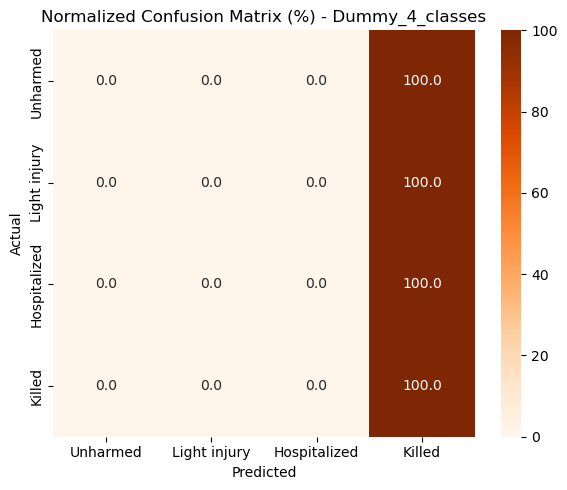


🔍 Tuning model: Logistic Regression_4_classes
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✅ Best parameters for Logistic Regression_4_classes: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.36      0.28      0.32     30786
           1       0.11      0.46      0.18      3675
           2       0.58      0.51      0.54     81661
           3       0.70      0.73      0.71    104427

    accuracy                           0.58    220549
   macro avg       0.44      0.49      0.44    220549
weighted avg       0.60      0.58      0.59    220549



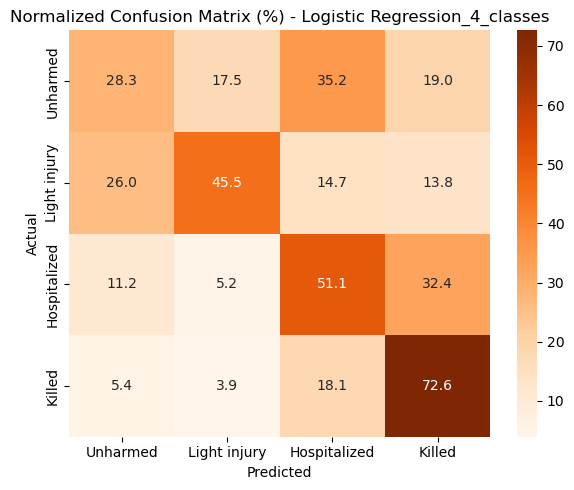


🔍 Tuning model: Decision Tree_4_classes
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Best parameters for Decision Tree_4_classes: {'classifier__max_depth': None, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.43      0.45      0.44     30786
           1       0.24      0.27      0.26      3675
           2       0.62      0.62      0.62     81661
           3       0.74      0.72      0.73    104427

    accuracy                           0.64    220549
   macro avg       0.51      0.52      0.51    220549
weighted avg       0.64      0.64      0.64    220549



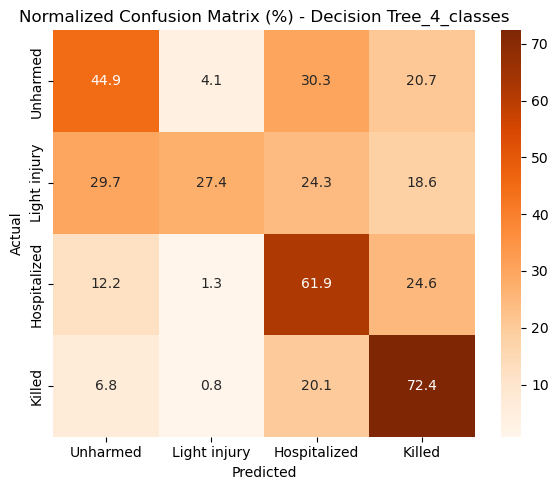

In [18]:
# Define models
models = {
    "Dummy_4_classes": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression_4_classes": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    "Decision Tree_4_classes": DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

# Hyperparameter grids
param_grids = {
    "Dummy_4_classes": {},
    "Logistic Regression_4_classes": {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l2']
    },
    "Decision Tree_4_classes": {
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# Define severity class labels
severity_labels = ['Unharmed', 'Light injury', 'Hospitalized', 'Killed']

# Dictionary to store results
results = {}

# Train, tune, and evaluate each model
for name, model in models.items():
    print(f"\n🔍 Tuning model: {name}")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        scoring='f1_macro',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)

    # Evaluation metrics
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

    # Save results
    results[name] = {
        "model_name": name,
        "best_params": search.best_params_,
        "classification_report": report_dict,
        "confusion_matrix": cm.tolist(),
        "confusion_matrix_percent": cm_percent.tolist()
    }

    print(f"\n✅ Best parameters for {name}: {search.best_params_}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Save normalized confusion matrix as heatmap
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
                xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
    ax.set_title(f"Normalized Confusion Matrix (%) - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()
    plt.close()

undersampling 


🔍 Tuning model: Logistic Regression_4_classes_undersampled
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✅ Best parameters for Logistic Regression_4_classes_undersampled: {'classifier__C': 10.0, 'classifier__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.28      0.26      0.27     30786
           1       0.08      0.69      0.14      3675
           2       0.59      0.44      0.50     81661
           3       0.72      0.67      0.70    104427

    accuracy                           0.53    220549
   macro avg       0.42      0.52      0.40    220549
weighted avg       0.60      0.53      0.56    220549



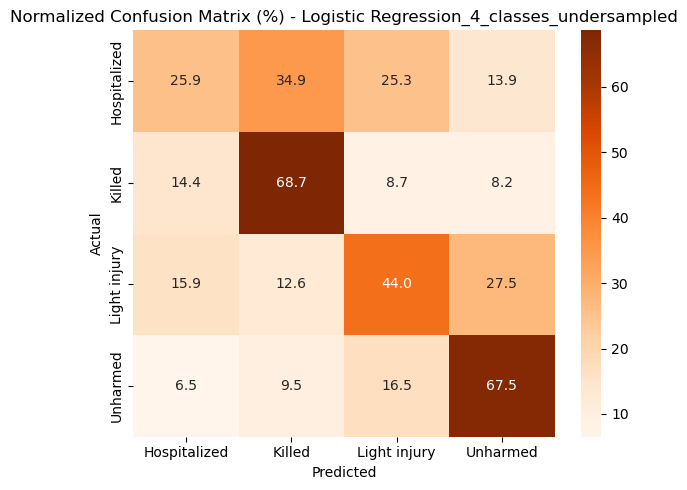


🔍 Tuning model: Decision Tree_4_classes_undersampled
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Best parameters for Decision Tree_4_classes_undersampled: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.27      0.23      0.25     30786
           1       0.07      0.64      0.13      3675
           2       0.55      0.54      0.55     81661
           3       0.76      0.61      0.67    104427

    accuracy                           0.53    220549
   macro avg       0.41      0.50      0.40    220549
weighted avg       0.60      0.53      0.56    220549



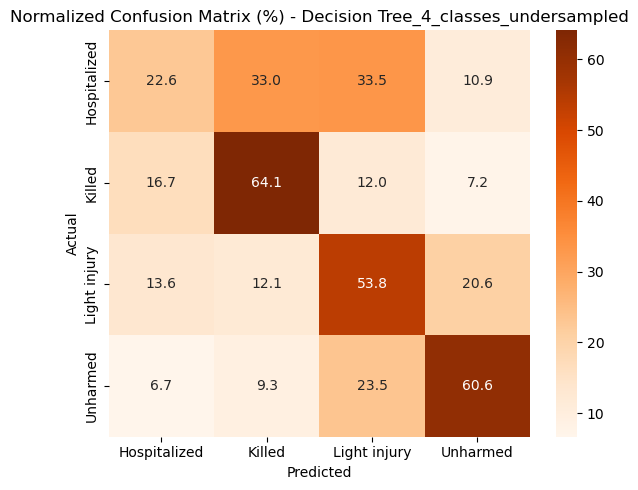

In [20]:
# Define models
models = {
    "Logistic Regression_4_classes_undersampled": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    "Decision Tree_4_classes_undersampled": DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

# Hyperparameter grids
param_grids = {
    "Logistic Regression_4_classes_undersampled": {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l2']
    },
    "Decision Tree_4_classes_undersampled": {
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# Labels and output containers
severity_labels = ['Hospitalized', 'Killed', 'Light injury', 'Unharmed']
results = {}

# Training and evaluation
for name, model in models.items():
    print(f"\n🔍 Tuning model: {name}")

    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("undersample", RandomUnderSampler(random_state=42)),
        ("classifier", model)
    ])

    search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        scoring='f1_macro',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)

    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

    results[name] = {
        "model_name": name,
        "best_params": search.best_params_,
        "classification_report": report_dict,
        "confusion_matrix": cm.tolist(),
        "confusion_matrix_percent": cm_percent.tolist()
    }

    print(f"\n✅ Best parameters for {name}: {search.best_params_}")
    print(classification_report(y_test, y_pred, zero_division=0))


    # 🟠 Normalized heatmap
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
                xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
    ax.set_title(f"Normalized Confusion Matrix (%) - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.tight_layout()
    plt.show()
    plt.close()

## RF_4_classes
**Description:**  
Random Forest trained on the **imbalanced dataset**. Each tree uses random feature splits and bootstrapping.  

**Trade-offs:**  
- ✅ Higher accuracy and robustness than a single DT.  
- ✅ Handles multiclass better than LR.  
- ❌ Still biased toward majority class if imbalance is large.  
- ❌ More complex and computationally demanding.  

---

## LR_undersampled_4_classes
**Description:**  
Multinomial Logistic Regression applied to an **undersampled dataset** to balance all four accident severity classes.  

**Trade-offs:**  
- ✅ Interpretable and simple baseline.  
- ✅ Works well on linearly separable features.  
- ❌ Limited ability to capture nonlinear relationships.  
- ❌ Sensitive to undersampling → may lose predictive power.  


🔍 Tuning model: Random Forest_4_classes
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest_4_classes: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.54      0.51      0.53     30786
           1       0.56      0.24      0.34      3675
           2       0.67      0.71      0.69     81661
           3       0.79      0.78      0.79    104427

    accuracy                           0.71    220549
   macro avg       0.64      0.56      0.59    220549
weighted avg       0.71      0.71      0.71    220549



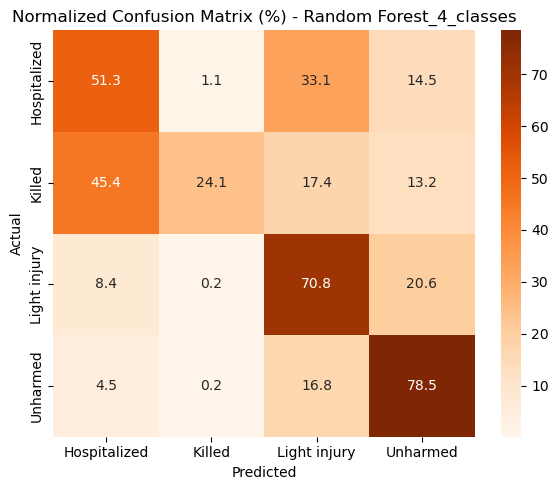

In [21]:
# Define model
model_name = "Random Forest_4_classes"
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Labels and paths
severity_labels = ['Hospitalized', 'Killed', 'Light injury', 'Unharmed']
results = {}

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

random forest with undersampling 


🔍 Tuning model: Random Forest_4_classes_undersampled
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Best parameters for Random Forest_4_classes_undersampled: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.29      0.35      0.32     30786
           1       0.10      0.73      0.17      3675
           2       0.59      0.48      0.53     81661
           3       0.76      0.65      0.70    104427

    accuracy                           0.55    220549
   macro avg       0.43      0.55      0.43    220549
weighted avg       0.62      0.55      0.57    220549



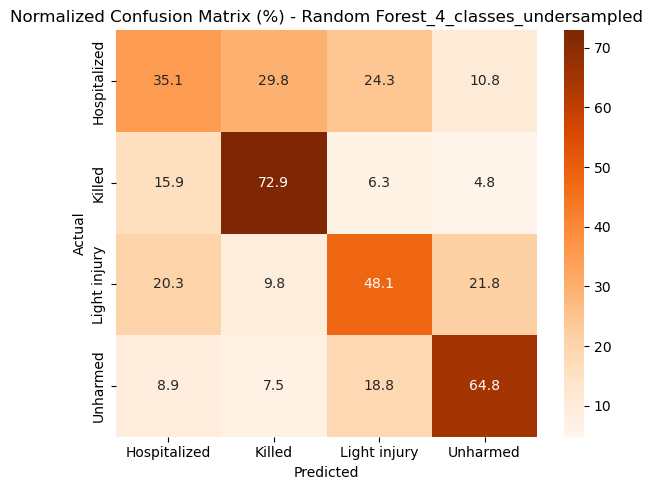

In [22]:
# Define model
model_name = "Random Forest_4_classes_undersampled"
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Labels and folders
severity_labels = ['Hospitalized', 'Killed', 'Light injury', 'Unharmed']
results = {}

# Pipeline with undersampling
pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("undersample", RandomUnderSampler(random_state=42)),
    ("classifier", model)
])

# Grid search
print(f"\n🔍 Tuning model: {model_name}")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
y_pred = search.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

## XGBoost_4_classes
**Description:**  
XGBoost gradient boosting model trained on the **full dataset** for 4-class prediction.  

**Trade-offs:**  
- ✅ Strong predictive power and ability to model complex patterns.  
- ✅ Outperforms simpler baselines in most cases.  
- ❌ Computationally expensive.  
- ❌ Bias toward majority class unless weighted or resampled.

## XGBoost_undersampled_4_classes
**Description:**  
XGBoost gradient boosting model trained after **undersampling majority classes** to enforce balance across four severity levels.  

**Trade-offs:**  
- ✅ Boosting helps capture complex patterns across classes.  
- ✅ Better recall on minority outcomes.  
- ❌ Undersampling reduces available training data.  
- ❌ Training cost is higher than tree/forest models. 


🔍 Tuning model: XGBoost_4_classes_randomsearch with randomized search
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best parameters for XGBoost_4_classes_randomsearch: {'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 1.0}
              precision    recall  f1-score   support

           0       0.47      0.26      0.34     30786
           1       0.47      0.04      0.07      3675
           2       0.57      0.64      0.61     81661
           3       0.71      0.76      0.73    104427

    accuracy                           0.63    220549
   macro avg       0.56      0.43      0.44    220549
weighted avg       0.62      0.63      0.62    220549



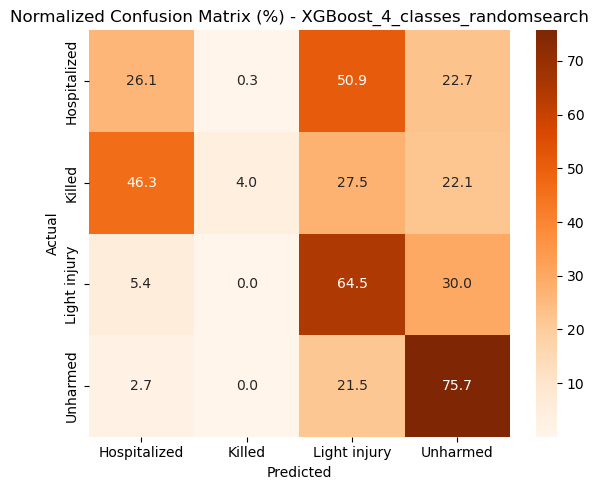

In [23]:
# Define model
model_name = "XGBoost_4_classes_randomsearch"
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

# Hyperparameter search space
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Labels and output tracking
severity_labels = label_encoder.classes_.tolist()
results = {}

# Randomized search
print(f"\n🔍 Tuning model: {model_name} with randomized search")
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring='f1_macro',
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
y_pred = search.best_estimator_.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

XGBoost (Undersampling)


🔍 Tuning model: XGBoost_4_classes_randomsearch_undersampled with randomized search + undersampling
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best parameters for XGBoost_4_classes_randomsearch_undersampled: {'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.8}
              precision    recall  f1-score   support

           0       0.28      0.34      0.31     30786
           1       0.09      0.71      0.16      3675
           2       0.58      0.49      0.53     81661
           3       0.77      0.63      0.69    104427

    accuracy                           0.54    220549
   macro avg       0.43      0.54      0.42    220549
weighted avg       0.62      0.54      0.57    220549



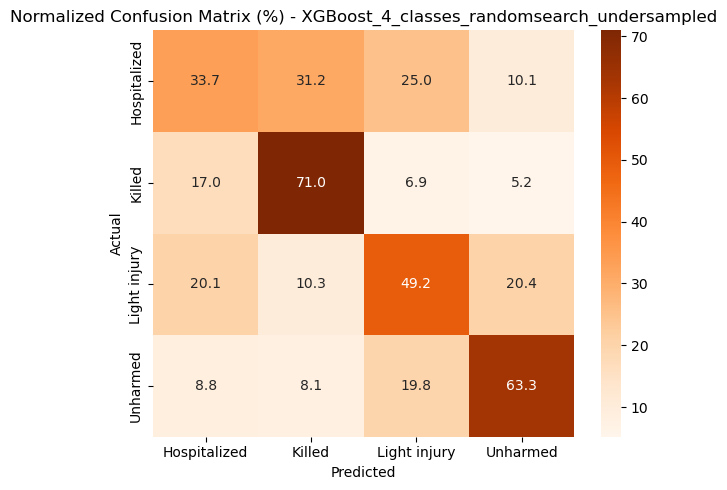

In [24]:
# Model setup
model_name = "XGBoost_4_classes_randomsearch_undersampled"
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

# Hyperparameter distribution
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Pipeline with undersampling
pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("undersample", RandomUnderSampler(random_state=42)),
    ("classifier", model)
])

# Labels
severity_labels = label_encoder.classes_.tolist()
results = {}

# Grid search
print(f"\n🔍 Tuning model: {model_name} with randomized search + undersampling")
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring='f1_macro',
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
y_pred = search.best_estimator_.predict(X_test)

# Evaluation
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

results[model_name] = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_percent.tolist()
}

print(f"\n✅ Best parameters for {model_name}: {search.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

# 🟠 Normalized heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Oranges",
            xticklabels=severity_labels, yticklabels=severity_labels, ax=ax)
ax.set_title(f"Normalized Confusion Matrix (%) - {model_name}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()